In [1]:
# import my librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import gsw

In [2]:
df = pd.read_csv('/f9139_P48.csv', header=0, names =['time','Smeas','Tmeas','Pmeas','Tcond'])
df['lon'] = -67.3622
df['lat']= 17.1281
df['Cmeas'] = gsw.C_from_SP(df['Smeas'], df['Tmeas'],df['Pmeas'])
df['SA'] = gsw.SA_from_SP(df['Smeas'],df['Pmeas'],df['lon'],df['lat'])
df['CT'] = gsw.CT_from_t(df['SA'], df['Tmeas'], df['Pmeas'])
df['sigma0'] = gsw.sigma0(df['SA'],df['CT'])
df['dpdt'] = np.gradient(df.Pmeas,df.time-df.time[0])
#df.dpdt[:] = np.nan

#for ii in np.arange(1,1882,1):
#    df.dpdt[ii] = 
#df.dpdt[1:-2] = (df.Pmeas[2:-1] - df.Pmeas[0:-3])/(df.time[2:-1] - df.time[0:-3])

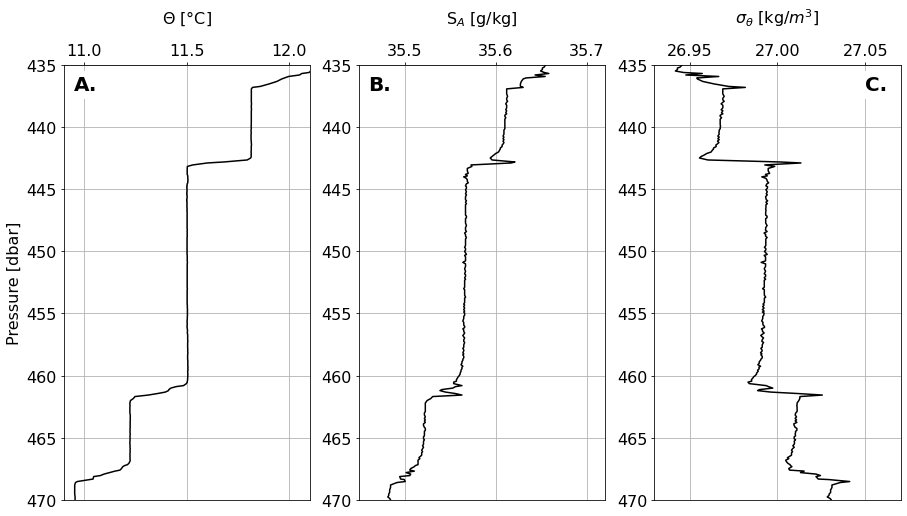

In [6]:
fig, ax = plt.subplots(1,3,figsize=(15,8))

# Temperature profile
ax[0].plot(df['CT'],df['Pmeas'], color='k')
ax[0].set_xlabel('$\Theta$ [°C]', fontsize=16)
ax[0].set_ylabel('Pressure [dbar]', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].set_ylim(435,470)
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].set_xlim(10.9,12.1)
ax[0].grid()
ax[0].xaxis.set_ticks_position('top') # the rest is the same
ax[0].xaxis.set_label_position('top') 
plt.setp(ax[0], xticks=[11, 11.5, 12])
ax[0].xaxis.labelpad = 20
ax[0].text(10.95, 437, 'A.', fontsize=20, fontweight='bold', backgroundcolor='w')

# Salinity profile
ax[1].plot(df['SA'],df['Pmeas'], color='k')
ax[1].set_xlabel('S$_{A}$ [g/kg]', fontsize=16)
#ax[1].set_ylabel('Pressure [dbar]', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].set_ylim(435,470)
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].set_xlim(35.45,35.72)
ax[1].grid()
ax[1].xaxis.set_ticks_position('top') # the rest is the same
ax[1].xaxis.set_label_position('top') 
plt.setp(ax[1], xticks=[35.5,35.6, 35.7])
ax[1].xaxis.labelpad = 20
ax[1].text(35.46, 437, 'B.', fontsize=20, fontweight='bold', backgroundcolor='w')

# Density profile
ax[2].plot(df['sigma0'],df['Pmeas'], color='k')
ax[2].set_xlabel('$\sigma_\\theta$ [kg/$m^3$]', fontsize=16)
#ax[2].set_ylabel('Pressure [dbar]', fontsize=16)
ax[2].tick_params(axis='both', which='major', labelsize=16)
ax[2].set_ylim(435,470)
ax[2].set_ylim(ax[2].get_ylim()[::-1])
ax[2].set_xlim(26.93,27.07)
ax[2].grid()
ax[2].xaxis.set_ticks_position('top') # the rest is the same
ax[2].xaxis.set_label_position('top') 
plt.setp(ax[2], xticks=[26.95,27,27.05])
ax[2].xaxis.labelpad = 20
ax[2].text(27.05, 437, 'C.', fontsize=20, fontweight='bold', backgroundcolor='w')


#plt.gca().invert_yaxis()
#plt.axis('tight')
#fig.tight_layout()  # otherwise the right y-label is slightly clipped

# save figure
plt.savefig("Fig2_f9139_P48.png",bbox_inches='tight')

Apply all dynamic corrections

In [7]:
# Coefficients
fs = 1
deltat = 0.35 # short-term temperature advance time in seconds
#ctcoeff = 1.08e-2 # long-term thermal ("tau_60")
ref_vel = 0.10;
ref_coef = 9.1e-3;
#ctcoeff = ref_coef/ref_vel**(-1.09)*(-df.dpdt)**(-1.09);
ctcoeff = 0.07*(-df.dpdt*100)**(-0.86)+7.5e-9;

#alpha = 0.13 # short-term thermal magnitude (Lueck and Picklo, 1990)
alpha = 0.50*11.3**-1.09
tau = 13.46*11.3**-0.22
beta = 1/tau # short-term thermal inverse time constant, 1/tau_8 (Lueck and Picklo, 1990)
fn = fs/2 # Nyquist frequency (half of logger sampling rate, fs)

## advance temperature by deltat to get Tcor
df['Tcor'] = np.interp(df['time'] + deltat, df['time'], df['Tmeas'])

## Apply CT cell internal temperature dynamic correction to get Ccor
df['Tlong'] = ctcoeff*(df['Tcond'] - df['Tcor'])

## Apply the Morison et al. (1994) version of the Lueck and Picklo (1990) correction to get Tcell
Tcortemp = np.interp(np.arange(np.min(df['time']),np.max(df['time'])+1,1), df['time'], df['Tcor'])

a = 4 * fn * alpha * (beta**(-1)) * (1 + 4 * fn * beta**(-1))**(-1)
b = 1 - 2 * a * alpha**(-1)
# tadj: temperature anomaly needed to estimate water temperature inside CT cell hole
Tshortemp = np.zeros(Tcortemp.shape)

for n in np.arange(0,len(Tshortemp)):
    if n == 0:
        Tshortemp[n] = 0
    else:
        Tshortemp[n] = -b * Tshortemp[n-1] + a * ( Tcortemp[n] - Tcortemp[n-1] );
    
    
df['Tshort'] = ""
df['Tshort'] = np.interp(df['time'],np.arange(np.min(df['time']),np.max(df['time'])+1,1),Tshortemp)
df['Tcell'] = df['Tcor'] - df['Tshort'] + df['Tlong'];

## compute Practical Salinity from Ccor (corrected conductivity),
# estimated water temperature in CT cell (Tcell), and measured pressure
df['Scor'] = gsw.SP_from_C(df['Cmeas'],df['Tcell'],df['Pmeas']);
df['SAcor'] = gsw.SA_from_SP(df['Scor'],df['Pmeas'],df['lon'],df['lat'])
df['CTcor'] = gsw.CT_from_t(df['SAcor'], df['Tcor'], df['Pmeas'])
df['sigma0cor'] = gsw.sigma0(df['SAcor'],df['CTcor'])


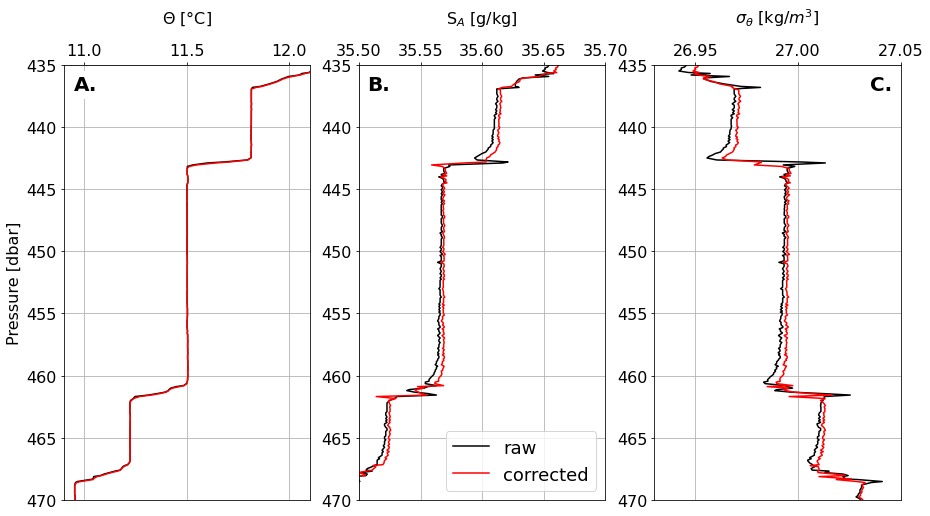

In [9]:
fig2, ax = plt.subplots(1,3,figsize=(15,8))

# Temperature profile
ax[0].plot(df['CT'],df['Pmeas'], color='k')
ax[0].plot(df['CTcor'],df['Pmeas'], color='r')
ax[0].set_xlabel('$\Theta$ [°C]', fontsize=16)
ax[0].set_ylabel('Pressure [dbar]', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].set_ylim(435,470)
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].set_xlim(10.9,12.1)
ax[0].grid()
ax[0].xaxis.set_ticks_position('top') # the rest is the same
ax[0].xaxis.set_label_position('top') 
plt.setp(ax[0], xticks=[11, 11.5, 12])
ax[0].xaxis.labelpad = 20
ax[0].text(10.95, 437, 'A.', fontsize=20, fontweight='bold', backgroundcolor='w')

# Salinity profile
ax[1].plot(df['SA'],df['Pmeas'], color='k', label = 'raw')
ax[1].plot(df['SAcor'],df['Pmeas'], color='r', label = 'corrected')
ax[1].set_xlabel('S$_A$ [g/kg]', fontsize=16)
#ax[1].set_ylabel('Pressure [dbar]', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].set_ylim(435,470)
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].set_xlim(35.5,35.7)
#ax[1].set_xlim(35.56,35.575)
ax[1].grid()
ax[1].xaxis.set_ticks_position('top') # the rest is the same
ax[1].xaxis.set_label_position('top') 
#plt.setp(ax[1], xticks=[35.5,35.6, 35.7])
ax[1].xaxis.labelpad = 20
ax[1].text(35.507, 437, 'B.', fontsize=20, fontweight='bold', backgroundcolor='w')
ax[1].legend(fontsize=18,loc=4)

# Density profile
ax[2].plot(df['sigma0'],df['Pmeas'], color='k')
ax[2].plot(df['sigma0cor'],df['Pmeas'], color='r')
ax[2].set_xlabel('$\sigma_\\theta$ [kg/$m^3$]', fontsize=16)
#ax[2].set_ylabel('Pressure [dbar]', fontsize=16)
ax[2].tick_params(axis='both', which='major', labelsize=16)
ax[2].set_ylim(435,470)
ax[2].set_ylim(ax[2].get_ylim()[::-1])
ax[2].set_xlim(26.93,27.05)
ax[2].grid()
ax[2].xaxis.set_ticks_position('top') # the rest is the same
ax[2].xaxis.set_label_position('top') 
plt.setp(ax[2], xticks=[26.95,27,27.05])
ax[2].xaxis.labelpad = 20
ax[2].text(27.035, 437, 'C.', fontsize=20, fontweight='bold', backgroundcolor='w')


#plt.gca().invert_yaxis()
#plt.axis('tight')
#fig.tight_layout()  # otherwise the right y-label is slightly clipped

# save figure
plt.savefig("Fig11_f9139_P48_corr.png",bbox_inches='tight')

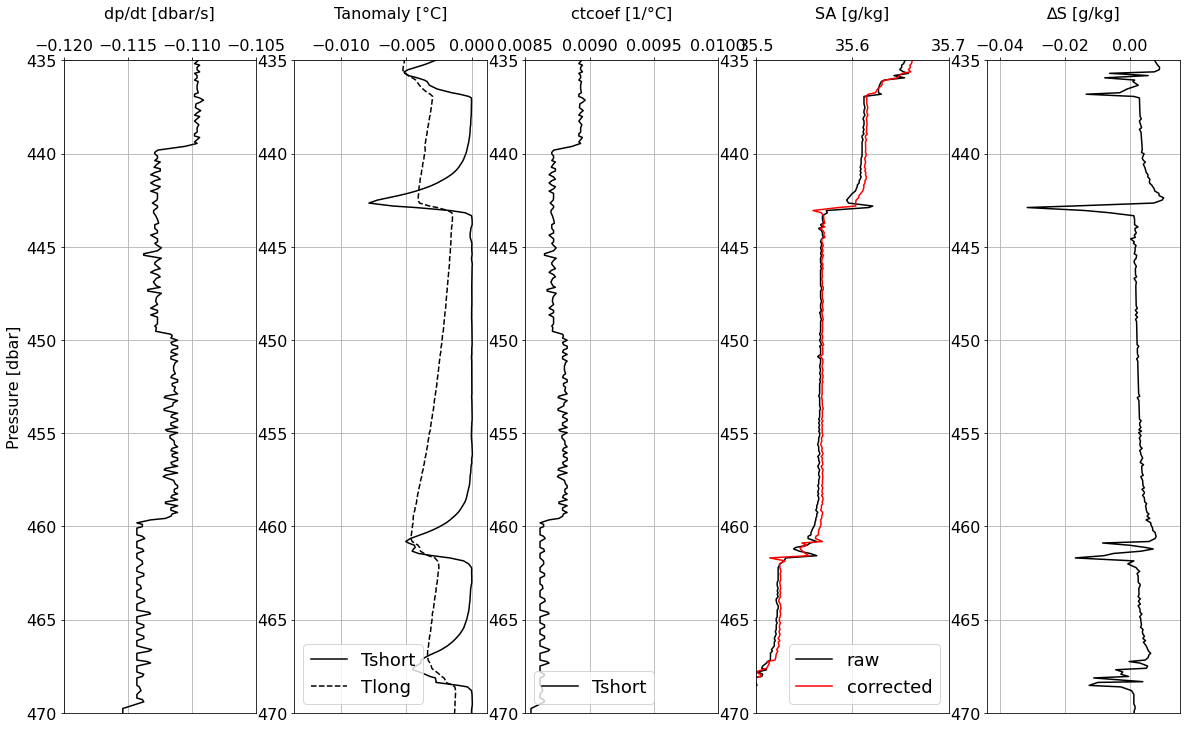

In [8]:
fig, ax = plt.subplots(1,5,figsize=(20,12))

# dpdt profile
ax[0].plot(df['dpdt'],df['Pmeas'], color='k')
ax[0].set_xlabel('dp/dt [dbar/s]', fontsize=16)
ax[0].set_ylabel('Pressure [dbar]', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].set_ylim(435,470)
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].set_xlim(-0.12,-0.105)
ax[0].grid()
ax[0].xaxis.set_ticks_position('top') # the rest is the same
ax[0].xaxis.set_label_position('top') 
#plt.setp(ax[0], xticks=[11, 11.5, 12])
ax[0].xaxis.labelpad = 20
#ax[0].text(10.95, 437, 'A.', fontsize=20, fontweight='bold', backgroundcolor='w')

# Tanomaly profile
ax[1].plot(-df['Tshort'],df['Pmeas'], color='k', label = 'Tshort')
ax[1].plot(df['Tlong'],df['Pmeas'], color='k', linestyle = '--', label ='Tlong')
ax[1].set_xlabel('Tanomaly [°C]', fontsize=16)
#ax[1].set_ylabel('Pressure [dbar]', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].set_ylim(435,470)
ax[1].set_ylim(ax[1].get_ylim()[::-1])
#ax[1].set_xlim(35.5,35.7)
#ax[1].set_xlim(35.55,35.58)
ax[1].grid()
ax[1].xaxis.set_ticks_position('top') # the rest is the same
ax[1].xaxis.set_label_position('top') 
#plt.setp(ax[1], xticks=[35.5,35.6, 35.7])
ax[1].xaxis.labelpad = 20
#ax[1].text(35.507, 437, 'B.', fontsize=20, fontweight='bold', backgroundcolor='w')
ax[1].legend(fontsize=18,loc=3)

# ctcoeff profile
ax[2].plot(ctcoeff,df['Pmeas'], color='k', label = 'Tshort')
ax[2].set_xlabel('ctcoef [1/°C]', fontsize=16)
#ax[2].set_ylabel('Pressure [dbar]', fontsize=16)
ax[2].tick_params(axis='both', which='major', labelsize=16)
ax[2].set_ylim(435,470)
ax[2].set_ylim(ax[2].get_ylim()[::-1])
ax[2].set_xlim(0.0085,0.01)
#ax[2].set_xlim(35.55,35.58)
ax[2].grid()
ax[2].xaxis.set_ticks_position('top') # the rest is the same
ax[2].xaxis.set_label_position('top') 
#plt.setp(ax[1], xticks=[35.5,35.6, 35.7])
ax[2].xaxis.labelpad = 20
#ax[1].text(35.507, 437, 'B.', fontsize=20, fontweight='bold', backgroundcolor='w')
ax[2].legend(fontsize=18,loc=3)


# Salinity profile
ax[3].plot(df['SA'],df['Pmeas'], color='k', label = 'raw')
ax[3].plot(df['SAcor'],df['Pmeas'], color='r', label = 'corrected')
ax[3].set_xlabel('SA [g/kg]', fontsize=16)
#ax[3].set_ylabel('Pressure [dbar]', fontsize=16)
ax[3].tick_params(axis='both', which='major', labelsize=16)
ax[3].set_ylim(435,470)
ax[3].set_ylim(ax[3].get_ylim()[::-1])
ax[3].set_xlim(35.5,35.7)
#ax[3].set_xlim(35.55,35.58)
ax[3].grid()
ax[3].xaxis.set_ticks_position('top') # the rest is the same
ax[3].xaxis.set_label_position('top') 
#plt.setp(ax[1], xticks=[35.5,35.6, 35.7])
ax[3].xaxis.labelpad = 20
#ax[3].text(35.507, 437, 'B.', fontsize=20, fontweight='bold', backgroundcolor='w')
ax[3].legend(fontsize=18,loc=4)

# ∆S profile
ax[4].plot(df['SAcor']-df['SA'],df['Pmeas'], color='k')
ax[4].set_xlabel('∆S [g/kg]', fontsize=16)
#ax[4].set_ylabel('Pressure [dbar]', fontsize=16)
ax[4].tick_params(axis='both', which='major', labelsize=16)
ax[4].set_ylim(435,470)
ax[4].set_ylim(ax[4].get_ylim()[::-1])
#ax[4].set_xlim(26.93,27.05)
ax[4].grid()
ax[4].xaxis.set_ticks_position('top') # the rest is the same
ax[4].xaxis.set_label_position('top') 
#plt.setp(ax[2], xticks=[26.95,27,27.05])
ax[4].xaxis.labelpad = 20
#ax[2].text(27.035, 437, 'C.', fontsize=20, fontweight='bold', backgroundcolor='w')


#plt.gca().invert_yaxis()
#plt.axis('tight')
#fig.tight_layout()  # otherwise the right y-label is slightly clipped

# save figure
#plt.savefig("Fig11_f9139_P48_corr.png",bbox_inches='tight')